# Studying glass classification

I'm trying to learn a bit more on 2 topics:

1. spotting and correcting skewed data
2. tuning the Random Forest Classifier parameters to achieve better results

## The data
This is the list of all the fields.

* Id number: 1 to 214 (removed from CSV file)
* RI: refractive index
* Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
* Mg: Magnesium
* Al: Aluminum
* Si: Silicon
* K: Potassium
* Ca: Calcium
* Ba: Barium
* Fe: Iron
* Type of glass: (class attribute)
  *  1 building_windows_float_processed
  * 2 building_windows_non_float_processed
  * 3 vehicle_windows_float_processed
  * 4 vehicle_windows_non_float_processed (none in this database)
  * 5 containers
  * 6 tableware
  * 7 headlamps

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Loading dataset and showing some records

In [10]:
#df = pd.read_csv('../input/glass.csv')
df = pd.read_csv('glass.csv')

df.sample(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
169,1.51994,13.27,0.00,1.76,73.03,0.47,11.32,0.00,0.00,5
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.00,0.00,1
31,1.51747,12.84,3.50,1.14,73.27,0.56,8.55,0.00,0.00,1
194,1.51683,14.56,0.00,1.98,73.29,0.00,8.52,1.57,0.07,7
163,1.51514,14.01,2.68,3.50,69.89,1.68,5.87,2.20,0.00,5


## Unbalanced classes

The classes in this dataset are not equally represented. Classes `3`, `5` and `6` are really poor and past analyses show that the algorithms struggle to classify data for them.

In [11]:
df.groupby(by='Type').count()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1,70,70,70,70,70,70,70,70,70
2,76,76,76,76,76,76,76,76,76
3,17,17,17,17,17,17,17,17,17
5,13,13,13,13,13,13,13,13,13
6,9,9,9,9,9,9,9,9,9
7,29,29,29,29,29,29,29,29,29


I try to find some common values in records for those classes. The goal is to duplicate data including some variation in order to "reinforce" the classification.

### Past results
Before doing it, I note here the past performances to see if there's an improvement.

This is the correlation between the features and the class:
* Mg      0.744993
* Al      0.598829
* Ba      0.575161
* Na      0.502898
* Fe      0.188278
* RI      0.164237
* Si      0.151565
* K       0.010054
* Ca      0.000952

This is the best estimator perf for a Random Forest:
```
0.7890625
{'n_estimators': 100, 'min_samples_split': 2, 'criterion': 'entropy', 'min_samples_leaf': 1}
```

And this is the cross-validation score:
`Score: 0.756`

Let's go.


### Generating random samples

I create some useful function that helps me create new samples for the "poor" classes using their mean and standard deviation values and setting to 0 a set of labels

In [14]:

# generate a -1 or +1 at random to add or subtract a random value from the mean
def random_sign():
    return [-1 if np.random.random()<.5 else 1]

# generate a new fake sample based on the passed means and standard deviations arrays,
# setting the passed Type value and the passed labels at zero
def gen_sample(mm, ss, type, labels_at_zero=[]):
    ix = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
    new = np.abs(mm + (ss * np.random.random(len(ix)) * random_sign() ))
    for l in labels_at_zero:
        new[l] = 0
    new['Type'] = type
    return new



In [15]:
# Class 6
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==6].describe().loc['mean',:]
stds = df[df['Type']==6].describe().loc['std',:]

# this was the full table, I took only the second and third row
df[df['Type']==6].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.0,9.0,9.0
mean,1.517456,14.646667,1.305556,1.366667,73.206667,0.0,9.356667,0.0,0.0,6.0
std,0.003116,1.084020,1.097134,0.571861,1.079467,0.0,1.449948,0.0,0.0,0.0
min,1.511150,13.790000,0.000000,0.340000,72.370000,0.0,6.650000,0.0,0.0,6.0
25%,1.518290,14.090000,0.000000,1.190000,72.500000,0.0,9.260000,0.0,0.0,6.0
50%,1.518880,14.400000,1.740000,1.560000,72.740000,0.0,9.570000,0.0,0.0,6.0
75%,1.519160,14.560000,2.240000,1.660000,73.480000,0.0,9.950000,0.0,0.0,6.0
max,1.519690,17.380000,2.410000,2.090000,75.410000,0.0,11.220000,0.0,0.0,6.0


In [16]:
# using a temp value
dfnew = df
for i in range(0, 20):
    dfnew = dfnew.append(gen_sample(means, stds, 6, ['Ba', 'Fe', 'K']), ignore_index=True)

In [17]:
# Let's check what happened
dfnew[dfnew['Type']==6].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.0,29.000000,29.0,29.0,29.0
mean,1.517424,14.704846,1.440938,1.343946,73.361526,0.0,9.392914,0.0,0.0,6.0
std,0.002252,0.723400,0.799815,0.404600,0.770968,0.0,1.009766,0.0,0.0,0.0
min,1.511150,13.790000,0.000000,0.340000,72.370000,0.0,6.650000,0.0,0.0,6.0
25%,1.515530,14.199276,0.815822,1.174607,72.760000,0.0,8.891821,0.0,0.0,6.0
50%,1.518207,14.560000,1.554455,1.373823,73.163414,0.0,9.570000,0.0,0.0,6.0
75%,1.519050,15.031868,2.190000,1.660000,73.901460,0.0,9.919977,0.0,0.0,6.0
max,1.520283,17.380000,2.410000,2.090000,75.410000,0.0,11.220000,0.0,0.0,6.0


In [18]:
dfnew[dfnew['Type']==5].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0
mean,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769,5.0
std,0.003345,0.777037,0.999146,0.693920,1.282319,2.138695,2.183791,0.608251,0.155588,0.0
min,1.513160,11.030000,0.000000,1.400000,69.890000,0.130000,5.870000,0.000000,0.000000,5.0
25%,1.516660,12.730000,0.000000,1.560000,72.180000,0.380000,9.700000,0.000000,0.000000,5.0
50%,1.519940,12.970000,0.000000,1.760000,72.690000,0.580000,11.270000,0.000000,0.000000,5.0
75%,1.521190,13.270000,1.710000,2.170000,73.390000,0.970000,11.530000,0.000000,0.000000,5.0
max,1.523690,14.010000,2.680000,3.500000,73.880000,6.210000,12.500000,2.200000,0.510000,5.0


Count raised to 29, so correctly +20. Standard deviation obviously decreased because I was adding random values inside the stddev range. Maybe this helps prediction too but I feel I'm corrupting the data a bit more than I wanted.

Now I do the same for the rest of the classes. BTW, I already checked that classes 3 and 5 do not have blank features.

In [19]:
# Class 3
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==3].describe().loc['mean',:]
stds = df[df['Type']==3].describe().loc['std',:]

for i in range(0, 13):
    dfnew = dfnew.append(gen_sample(means, stds, 3, []), ignore_index=True)

# Class 5
# Selecting the 'mean' and 'std' columns from the describe() to generate random values for the class
means = df[df['Type']==5].describe().loc['mean',:]
stds = df[df['Type']==5].describe().loc['std',:]
for i in range(0, 17):
    dfnew = dfnew.append(gen_sample(means, stds, 5, []), ignore_index=True)

### A final check on the data

In [20]:
dfnew.groupby(by='Type').count()


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1.0,70,70,70,70,70,70,70,70,70
2.0,76,76,76,76,76,76,76,76,76
3.0,30,30,30,30,30,30,30,30,30
5.0,30,30,30,30,30,30,30,30,30
6.0,29,29,29,29,29,29,29,29,29
7.0,29,29,29,29,29,29,29,29,29


In [21]:
df = dfnew

### X and Y
Dropping the class (`Type` column) from the X set and moving it in the Y set

In [22]:
X = df.drop(['Type'], axis=1)
Y = df['Type']

How the features influence the classification

In [23]:
df.corr()['Type'].abs().sort_values(ascending=False)

Type    1.000000
Mg      0.754146
Al      0.527947
Na      0.519392
Ba      0.488792
Si      0.233622
Fe      0.199825
RI      0.144169
Ca      0.092803
K       0.033707
Name: Type, dtype: float64

### Calculating data skewness and possibly unskewing

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


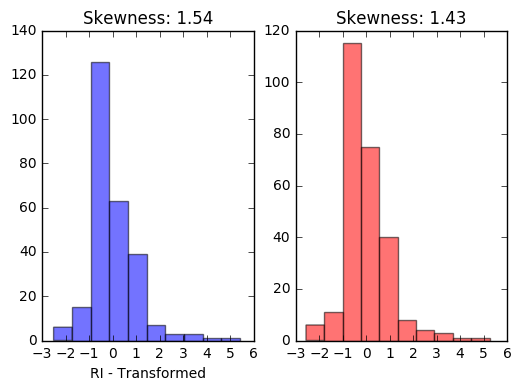

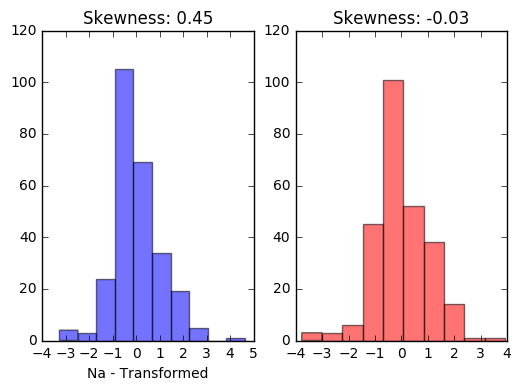

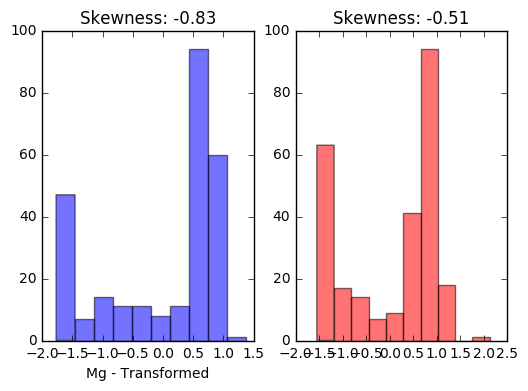

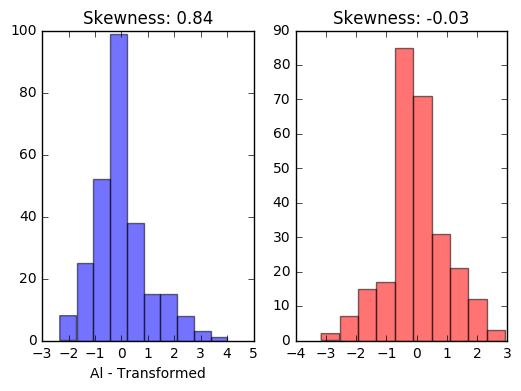

/opt/conda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:152: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


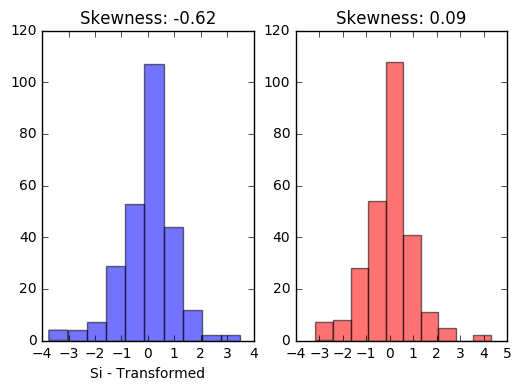

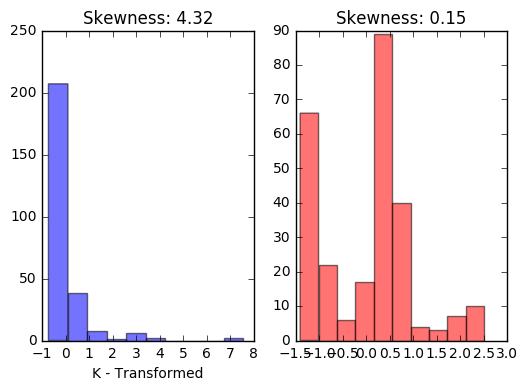

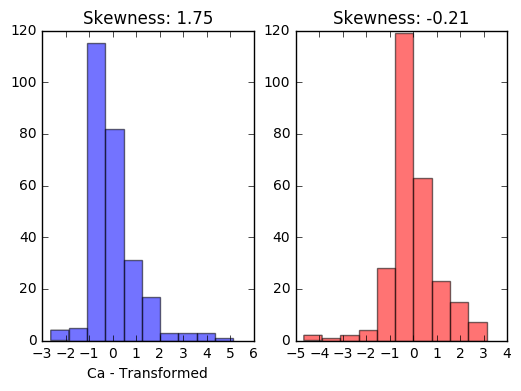

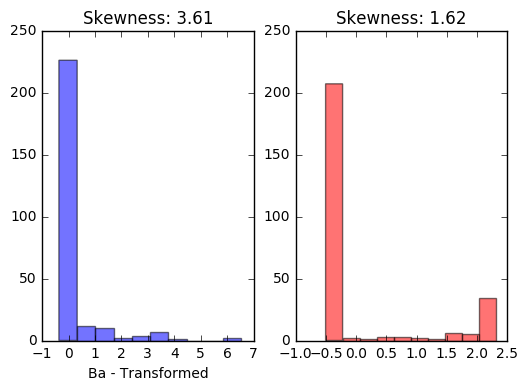

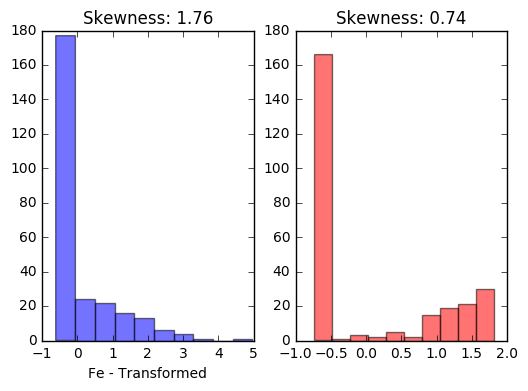

In [24]:
import matplotlib.pylab as plt
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# getting features names to loop
classes = X.columns.values

# This will contain the unskewed features
X_unsk = pd.DataFrame()

# looping through the 
for c in classes:
    scaled = preprocessing.scale(X[c]) 
    boxcox_scaled = preprocessing.scale(boxcox(X[c] + np.max(np.abs(X[c]) +1) )[0])
    
    # Populating 
    X_unsk[c] = boxcox_scaled
    
    #Next We calculate Skewness using skew in scipy.stats
    skness = skew(scaled)
    boxcox_skness = skew(boxcox_scaled)
    
    #We draw the histograms 
    figure = plt.figure()
    # First the original data shape
    figure.add_subplot(121)   
    plt.hist(scaled,facecolor='blue',alpha=0.55) 
    plt.xlabel(c + " - Transformed") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    
    # then the unskewed
    figure.add_subplot(122) 
    plt.hist(boxcox_scaled,facecolor='red',alpha=0.55) 
    plt.title("Skewness: {0:.2f}".format(boxcox_skness)) 

    plt.show()

In most cases the BoxCox unskewing is successfully transforming the data

## Hyperparameters

Searching the best parameters for the Random Forest Classifier 

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import math

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.40, random_state=42)

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "criterion" : ["gini", "entropy"]
              , "min_samples_leaf" : [1, 5, 10]
              , "min_samples_split" : [2, 4, 10, 12, 16]
              , "n_estimators": [100, 125, 200]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   17.4s finished


### Score

Printing best score performance and algorithm parameters

In [26]:
print(gs.best_score_)
print(gs.best_params_)

0.835443037975
{'min_samples_split': 4, 'n_estimators': 100, 'criterion': 'entropy', 'min_samples_leaf': 1}


### Training

Final training with the best hyperparameters found by GridSearchCV

In [27]:
bp = gs.best_params_
rf = RandomForestClassifier( criterion=bp['criterion'], 
                             n_estimators=bp['n_estimators'],
                             min_samples_split=bp['min_samples_split'],
                             min_samples_leaf=bp['min_samples_leaf'],
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

rf.fit(X_tr, y_tr)
pred = rf.predict(X_ts)

score = rf.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.736


Works better on the training set but worse on the validation. It looks like the fake data is overfitting the algorithm.

### Features importance
This is the features importances for the algorithm

In [28]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,Mg,0.233482
3,Al,0.160872
1,Na,0.134724
5,K,0.128680
6,Ca,0.102880
0,RI,0.084257
4,Si,0.066605
7,Ba,0.062068
8,Fe,0.026432


Taking a look at the confusion matrix.

Confusion matrix, without normalization
[[20  5  0  0  0  0]
 [11 22  0  0  1  1]
 [ 6  0  5  0  0  0]
 [ 0  2  0  9  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  2  0 10]]


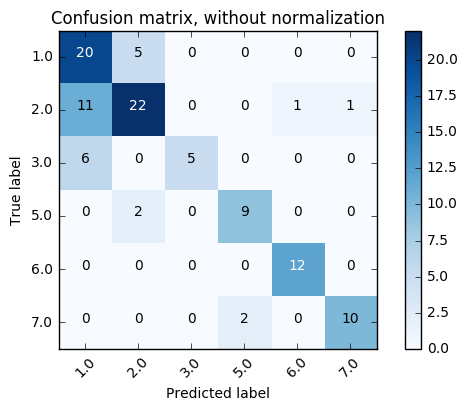

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
#print(y_ts.values)
#print(pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

Classes 3, 4 and 5 are ok now but I corrupted 1 and 2!!

## Trying with XGBoost

As suggested in the comments, I try to compare this Random Forest model with an XGBoost to see how both perform with this dataset.

In [30]:
from xgboost import XGBClassifier

# Here I use the unskewed dataset
X = X_unsk
X_tr, X_ts, y_tr, y_ts = train_test_split(X, Y, test_size=0.4, random_state=42)
xgb = XGBClassifier()

param_grid = { "max_depth" : [5]
              , "learning_rate" : [0.1, 0.125, 0.2]
              , "n_estimators": [50, 100]
              , "reg_lambda": [.01, .1, .5]}
gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
gs = gs.fit(X_tr, y_tr)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   53.4s finished


In [31]:
print(gs.best_score_)
print(gs.best_params_)

0.772151898734
{'learning_rate': 0.2, 'n_estimators': 50, 'max_depth': 5, 'reg_lambda': 0.5}


The score on the TS is a bit worse than the RF even though I tried many parameters combination.

In [32]:
bp = gs.best_params_
xgb = XGBClassifier( max_depth=bp['max_depth'], 
                             n_estimators=bp['n_estimators'],
                             learning_rate=bp['learning_rate'],
                   reg_lambda=bp['reg_lambda'])

xgb.fit(X_tr, y_tr)
pred = xgb.predict(X_ts)

score = xgb.score(X_ts, y_ts)
print("Score: %.3f" % (score))

Score: 0.736


XGBoost instead has gone better.

The feature importance matrix is slightly different from the RF's one.

In [33]:
pd.concat((pd.DataFrame(X.columns, columns = ['variable']), 
           pd.DataFrame(xgb.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,Mg,0.193416
0,RI,0.190947
6,Ca,0.123457
1,Na,0.116872
3,Al,0.113580
5,K,0.094650
4,Si,0.093827
8,Fe,0.037860
7,Ba,0.035391


Confusion matrix, without normalization
[[16  5  4  0  0  0]
 [ 7 22  3  2  1  0]
 [ 2  0  9  0  0  0]
 [ 0  3  0  8  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  1  0 11]]


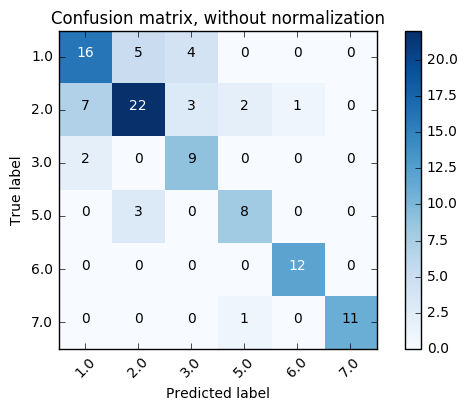

In [34]:
cnf_matrix = confusion_matrix(y_ts.values, pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=np.sort(y_ts.unique()), normalize=False,
                      title='Confusion matrix, without normalization')

Again the issue here are features 1 and 2 that worked a lot better before the fake data was introduced.

## Conclusions

OLD COMMENT:
> I'm really a novice in ML but I'm trying to apply all the interesting stuff I find in many awesome Kaggle kernels and discussions in order to slowly learn how work with data.
> In this case I've learned a bit more about feature skewing, Random Forest parameters tuning and I did some experiment with XGBoost but the kernel is really far from defining a decent classifier for the glass classification problem. Maybe I need to study more the dataset and to try other classifiers.

NEW COMMENT:
I tried to fix the poor performance of this small dataset adding fake values, similar to the existing ones, for the less represented classes. It has not worked as I expected, maybe I added too much data or maybe someone has a better explanation out there!

Anyway, any advice is welcome!